In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math

def plot_embs_2d(X, y, kept_indices=None):

    if(kept_indices is None):
        kept_indices = np.arange(len(X), dtype=int) # take all instances
    else:
        kept_indices = np.array(kept_indices)

    X_filtered = X[kept_indices]

    # Plot
    plt.figure(figsize=(12, 8))
    for i in range(2): # 2 classes
        plt.scatter(X_filtered[y[kept_indices] == i, 0], X_filtered[y[kept_indices] == i, 1], label=f'Class {i}', alpha=0.7)  
        
    plt.title(f"Visualización 2D")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

19


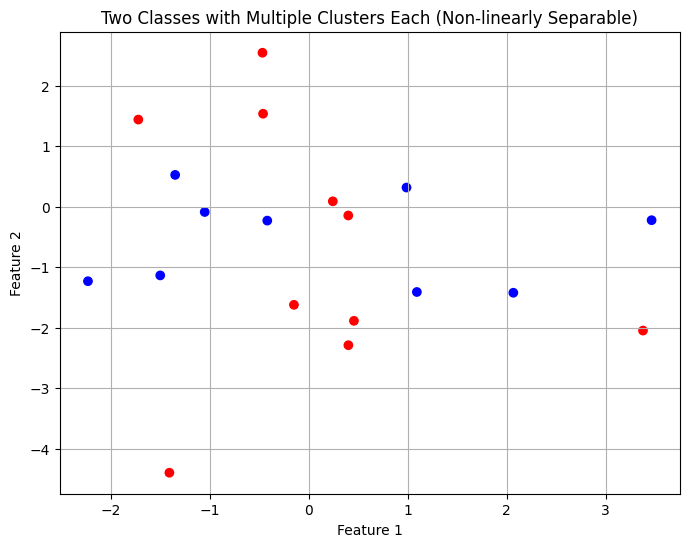

In [186]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from collections import defaultdict
import random

# we want non-linearly separable clusters

# Define centers: two clusters per class, so four total clusters
centers = [(-2, -1), (0, 2), (2, 0), (1, -2)]

# Each of the 4 clusters will belong to one of two classes
X, labels = make_blobs(n_samples=16, centers=centers, cluster_std=1.0, random_state=42)

# Map the 4 clusters to 2 classes
# For example: clusters 0 and 1 -> class 0; clusters 2 and 3 -> class 1
cluster_to_class = {0: 0, 1: 1, 2: 0, 3: 1}
y = np.array([cluster_to_class[i] for i in labels])

# Add uniform random noise (e.g., 20% of data size)
n_noise = int(0.2 * len(X))
noise = np.random.uniform(low=-5, high=5, size=(n_noise, 2))
X = np.vstack([X, noise])
y = np.hstack([y, np.random.randint(0, 2, size=n_noise)])  # random class for noise

print(len(X))

# Plot the result
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr')
plt.title("Two Classes with Multiple Clusters Each (Non-linearly Separable)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

### Formulating the QUBO problem

#### 1. LSSm

In [187]:
def ne_dist(labels, distances):
    '''
    Vectorized Nearest Enemy computation.
    '''
    labels = np.array(labels)
    n = len(labels)
    ne = np.full(n, -1, dtype=int)

    # Create a mask where entries are True if the pair has different labels
    enemy_mask = labels[:, None] != labels[None, :]

    # Set same-class distances to np.inf to ignore them
    masked_distances = np.where(enemy_mask, distances, np.inf)

    # Find the index of the minimum distance in each row
    ne = np.argmin(masked_distances, axis=1)

    return ne

In [188]:
def compute_local_sets(X, y, kept_indices=None):
    '''
    Compute local sets and sort them by increasing Local Set Cardinality (LSC),
    restricted to instances in `kept_indices`.

    Parameters:
    - labels: (n,) full label array
    - ne: (n,) nearest enemy indices in original space
    - distances: (n, n) full pairwise distance matrix
    - kept_indices: list or array of indices to keep (subset of full data)

    Returns:
    - LSs: dict of local sets for each kept index
    - sorted_LSs_dict: dict of kept index → local set (sorted by LSC)
    '''
    from collections import defaultdict
    import numpy as np
    from sklearn.metrics.pairwise import euclidean_distances

    if(kept_indices is None):
        kept_indices = np.arange(len(y), dtype=int) # take all instances
    else:
        kept_indices = np.array(kept_indices)

    X_filtered = X[kept_indices]
    y_filtered = y[kept_indices]

    distances_filtered = euclidean_distances(X_filtered, X_filtered)
    NEs_filtered = ne_dist(y_filtered, distances_filtered)
    
    LSs = defaultdict(list)
    lsc_map = []

    for i, real_index in enumerate(kept_indices):
        same_class = (y_filtered == y_filtered[i])
        closer_than_enemy = (distances_filtered[i] <= distances_filtered[i][NEs_filtered[i]])
        mask = same_class & closer_than_enemy
        LS = kept_indices[mask].tolist()

        # Ensure i is included if appropriate
        if real_index not in LS:
            LS.append(real_index)

        LSs[int(real_index)] = LS
        lsc_map.append((int(real_index), len(LS)))

    # Sort by increasing local set size
    lsc_map.sort(key=lambda x: x[1])

    # Create sorted dict
    sorted_LSs_dict = defaultdict(list)
    for i, _ in lsc_map:
        sorted_LSs_dict[int(i)] = LSs[int(i)]

    return LSs, sorted_LSs_dict

In [189]:
import matplotlib.pyplot as plt
import random as random
import math

def print_local_sets(X, y, kept_indices=None):
    '''
    Plots a scatter plot with embeddings and their local sets. The local set of an instance e is the set of instances 
    whose distance to e is smaller than the distance between e and its nearest ennemy.
    '''

    if(kept_indices is None):
        kept_indices = np.arange(len(y), dtype=int) # take all instances
    else:
        kept_indices = np.array(kept_indices)

    X_filtered = X[kept_indices]
    y_filtered = y[kept_indices]

    distances_filtered = euclidean_distances(X_filtered, X_filtered)
    NEs_filtered = ne_dist(y_filtered, distances_filtered)
    
    fig, ax = plt.subplots(figsize=(10, 10))

    color = []
    
    for i in range(2): # number of classes
        r = random.random() 
        b = random.random() 
        g = random.random() 
  
        color.append((r, g, b))

        kept_mask = (np.isin(np.arange(len(X)), kept_indices)) & (y == i) 
        plt.scatter(X[kept_mask, 0], X[kept_mask, 1], label=f'Class {i}', s=300, alpha=0.7,color=color[i])

    for i, real_index in enumerate(kept_indices):
        
        # Add index text inside the point
        plt.text(X[real_index][0], X[real_index][1], str(real_index), fontsize=10, ha='center', va='center', color='white',
                 bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.2'))
        
        # Add circles for Local Sets
        radius = math.dist(X[real_index], X[NEs_filtered[i]])
        LSR_normalized= 1/(1 + np.exp(-radius)) # regulate opacity with the LSR

        if y[real_index] == 0:
            circle = plt.Circle(X[real_index], radius, color=color[0], fill=False, linewidth=LSR_normalized, alpha=LSR_normalized)
            ax.add_patch(circle)
        else:
            circle = plt.Circle(X[real_index], radius, color=color[1], fill=False, linewidth=LSR_normalized, alpha=LSR_normalized)
            ax.add_patch(circle)

    plt.legend()
    plt.grid(True)
     
    ax.set_aspect('equal')

    plt.show()

defaultdict(<class 'list'>, {0: [0, 7, 13], 1: [1], 2: [2, 4, 12], 3: [3, 15], 4: [2, 4, 12], 5: [5], 6: [6], 7: [0, 7, 13], 8: [8, 16], 9: [9, 16], 10: [9, 10, 11, 16], 11: [8, 9, 10, 11, 16], 12: [12], 13: [0, 7, 13], 14: [6, 14], 15: [3, 15], 16: [8, 9, 10, 16], 17: [17], 18: [0, 7, 13, 18]})

defaultdict(<class 'list'>, {1: [1], 5: [5], 6: [6], 12: [12], 17: [17], 3: [3, 15], 8: [8, 16], 9: [9, 16], 14: [6, 14], 15: [3, 15], 0: [0, 7, 13], 2: [2, 4, 12], 4: [2, 4, 12], 7: [0, 7, 13], 13: [0, 7, 13], 10: [9, 10, 11, 16], 16: [8, 9, 10, 16], 18: [0, 7, 13, 18], 11: [8, 9, 10, 11, 16]})


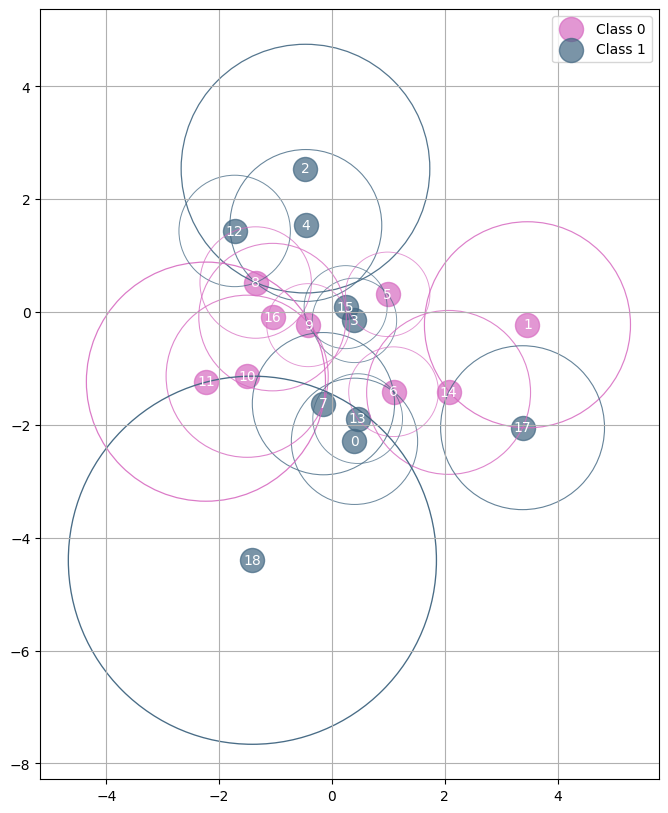

In [190]:
LSs, sorted_LSs_dict = compute_local_sets(X, y, None)
print(LSs)
print()
print(sorted_LSs_dict)
print_local_sets(X, y, None)

In [199]:
%%time

def local_set_based_smoother(X, y):
    """
    Local Set Based Smoother (noise filtering).
    
    Keeps points where the number of local sets the point appears in 
    is greater than the number of times it is a nearest enemy.

    Parameters:
    - X: (n_samples, n_features) data array
    - y: (n_samples,) label array
    - ne: (n_samples,) index of nearest enemy for each point
    - distances: (n_samples, n_samples) full pairwise distance matrix

    Returns:
    - kept_indices: indices of retained points (relative to original X)
    """
    import numpy as np
    from collections import defaultdict

    n = len(y)
    LSs, _ = compute_local_sets(X, y)
    distances = euclidean_distances(X, X)
    NEs = ne_dist(y, distances)

    # Count how many local sets each point appears in
    usefulness = np.zeros(n, dtype=int)
    for LS in LSs.values():
        for idx in LS:
            usefulness[idx] += 1

    # Count how many times each point is the nearest enemy
    harmfulness = np.zeros(n, dtype=int)
    for enemy in NEs:
        harmfulness[enemy] += 1

    # Apply the smoother condition
    mask = usefulness >= harmfulness
    kept_indices = np.where(mask)[0]
    noise_indices= np.where(np.logical_not(mask))[0]

    return kept_indices, noise_indices

kept_indices, noise_indices = local_set_based_smoother(X, y)
print(len(kept_indices))
print(len(noise_indices))

17
2
CPU times: total: 0 ns
Wall time: 993 μs


In [200]:
print(noise_indices)

[ 6 17]


In [201]:
def plot_noise(X, y, noise_indices):
    
    num_points = len(X)

    noise_indices = np.array(noise_indices)

    print(f"Noise points: {len(noise_indices)}")

    colors = ['magenta', 'green']

    plt.figure(figsize=(10, 8))

    for i in range(2):  # Assuming 2 classes
        # All points of class i (faded)
        plt.scatter(X[y == i, 0], X[y == i, 1], label=f'Class {i}', alpha=0.3, color=colors[i], s=300)

    # Noise points (cross)
    if len(noise_indices) > 0:
        plt.scatter(X[noise_indices, 0], X[noise_indices, 1], color='red', marker='x', s=200, label='Noise')

    # Index labels
    for i, x in enumerate(X):
        plt.text(x[0], x[1], str(i), fontsize=10, ha='center', va='center', color='white',
                 bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.2'))

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Noise Points')
    plt.legend()
    plt.grid(True)
    plt.show()

Noise points: 2


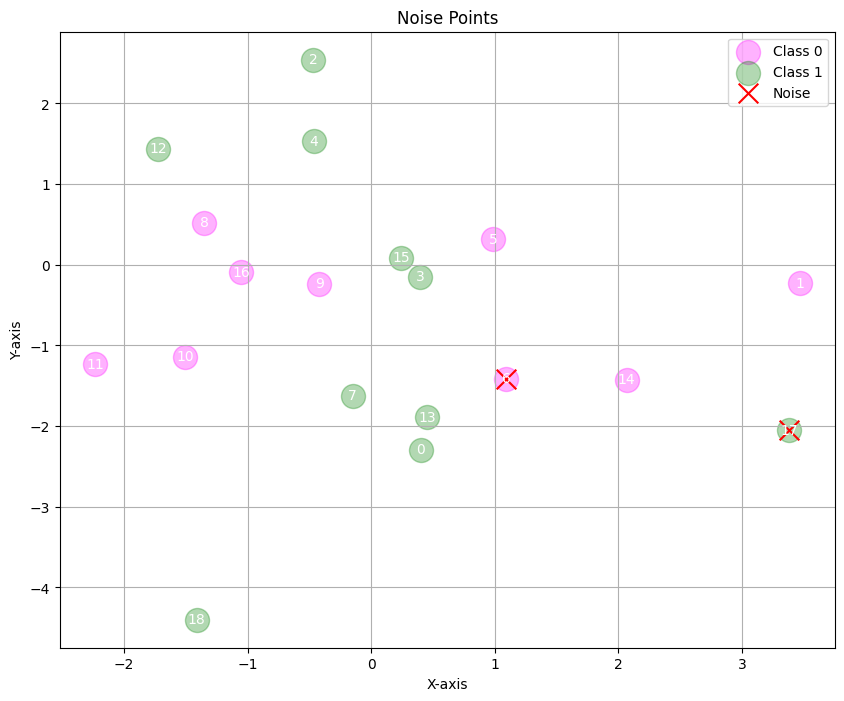

In [202]:
plot_noise(X, y, noise_indices)

In [203]:
kept_indices

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18])

defaultdict(<class 'list'>, {0: [0, 7, 13], 1: [1, 5, 14], 2: [2, 4, 12], 3: [3, 15], 4: [2, 4, 12], 5: [5], 7: [0, 7, 13], 8: [8, 16], 9: [9, 16], 10: [9, 10, 11, 16], 11: [8, 9, 10, 11, 16], 12: [12], 13: [0, 7, 13], 14: [14], 15: [3, 15], 16: [8, 9, 10, 16], 18: [0, 7, 13, 18]})

defaultdict(<class 'list'>, {5: [5], 12: [12], 14: [14], 3: [3, 15], 8: [8, 16], 9: [9, 16], 15: [3, 15], 0: [0, 7, 13], 1: [1, 5, 14], 2: [2, 4, 12], 4: [2, 4, 12], 7: [0, 7, 13], 13: [0, 7, 13], 10: [9, 10, 11, 16], 16: [8, 9, 10, 16], 18: [0, 7, 13, 18], 11: [8, 9, 10, 11, 16]})


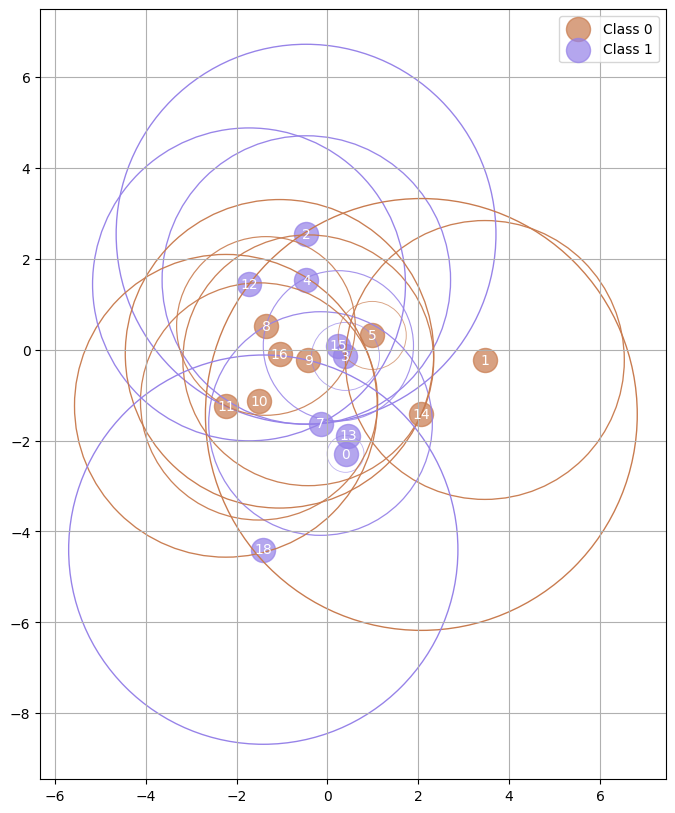

In [204]:
LSs, sorted_LSs_dict = compute_local_sets(X, y, kept_indices)
print(LSs)
print()
print(sorted_LSs_dict)
print_local_sets(X, y, kept_indices)

In [205]:
def local_set_border_selector(X, y, selected_indices):
    """
    Local Set Border Selector
    
    Algorithm to retain border instances. 
    An instance is a border instance if it has the lower LSC among the members of its LS.

    Parameters:
    - X: (n_samples, n_features) data array
    - y: (n_samples,) label array
    - ne: (n_samples,) index of nearest enemy for each point
    - distances: (n_samples, n_samples) full pairwise distance matrix
    - kept_indices: indices of retained points (relative to original X) after noise filtering with LSSm

    Returns:
    - kept_indices: indices of retained points (relative to original X)
    """
    import numpy as np
    from collections import defaultdict

    LSs, sorted_LSs_dict = compute_local_sets(X, y, selected_indices)

    borders = set()
    for key, val in sorted_LSs_dict.items():
        LS_members = set(val)
        if len(LS_members.intersection(borders)) == 0:
            borders.add(key)

    borders = list(borders)
    return borders

In [206]:
def plot_borders(X, y, kept_indices, border_indices):

    X_filtered = X[kept_indices]
    y_filtered = y[kept_indices]

    num_points = len(X)
    num_points_filtered = len(X_filtered)

    border_indices = np.array(border_indices)

    print(f"Border points: {len(border_indices)}")

    colors = ['magenta', 'green']

    plt.figure(figsize=(10, 8))

    for i in range(2):  # Assuming 2 classes
        # All points of class i (faded)
        plt.scatter(X_filtered[y_filtered == i, 0], X_filtered[y_filtered == i, 1], label=f'Class {i}', alpha=0.3, color=colors[i], s=300)

        # Border points with triangle
        border_mask = (y == i) & (np.isin(np.arange(num_points), border_indices))
        plt.scatter(X[border_mask, 0], X[border_mask, 1],
                    alpha=1, color=colors[i], marker='^', s=250, label=f'Borders Class {i}')
        
    # Index labels
    for i, real_index in enumerate(kept_indices):
        plt.text(X_filtered[i][0], X_filtered[i][1], str(real_index), fontsize=10, ha='center', va='center', color='white',
                 bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.2'))

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Border Points')
    plt.legend()
    plt.grid(True)
    plt.show()

7
[0, 3, 5, 8, 9, 12, 14]
Border points: 7


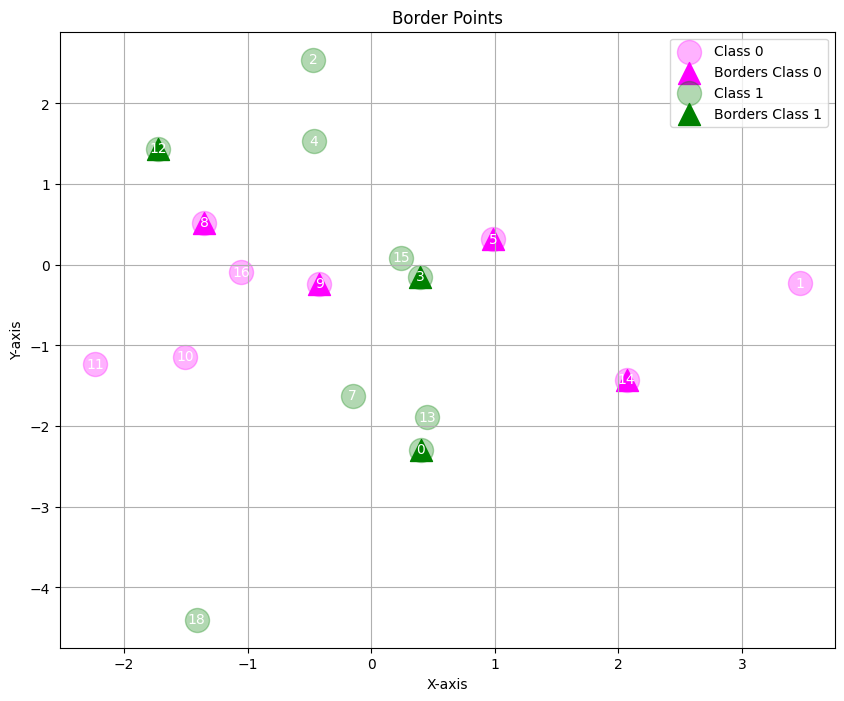

In [207]:
borders_lsbo = local_set_border_selector(X, y, kept_indices)

print(len(borders_lsbo))
print(borders_lsbo)
plot_borders(X, y, kept_indices, borders_lsbo)

In [208]:
central_indices = list(set(kept_indices.tolist()).difference(set(borders_lsbo)))
print(central_indices)

[1, 2, 4, 7, 10, 11, 13, 15, 16, 18]


In [209]:
def plot_central(X, y, kept_indices, central_indices):

    X_filtered = X[kept_indices]
    y_filtered = y[kept_indices]

    num_points = len(X)
    num_points_filtered = len(X_filtered)

    central_indices = np.array(central_indices)

    print(f"Central points: {len(central_indices)}")

    colors = ['magenta', 'green']

    plt.figure(figsize=(10, 8))

    for i in range(2):  # Assuming 2 classes
        # All points of class i (faded)
        plt.scatter(X_filtered[y_filtered == i, 0], X_filtered[y_filtered == i, 1], label=f'Class {i}', alpha=0.3, color=colors[i], s=300)

        # Central points with cercle
        central_mask = (y == i) & (np.isin(np.arange(num_points), central_indices))
        plt.scatter(X[central_mask, 0], X[central_mask, 1],
                    alpha=1, color=colors[i], marker='o', s=250, label=f'Centrals Points Class {i}')
        
    # Index labels
    for i, real_index in enumerate(kept_indices):
        plt.text(X_filtered[i][0], X_filtered[i][1], str(real_index), fontsize=10, ha='center', va='center', color='white',
                 bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.2'))

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Central Points')
    plt.legend()
    plt.grid(True)
    plt.show()

Central points: 10


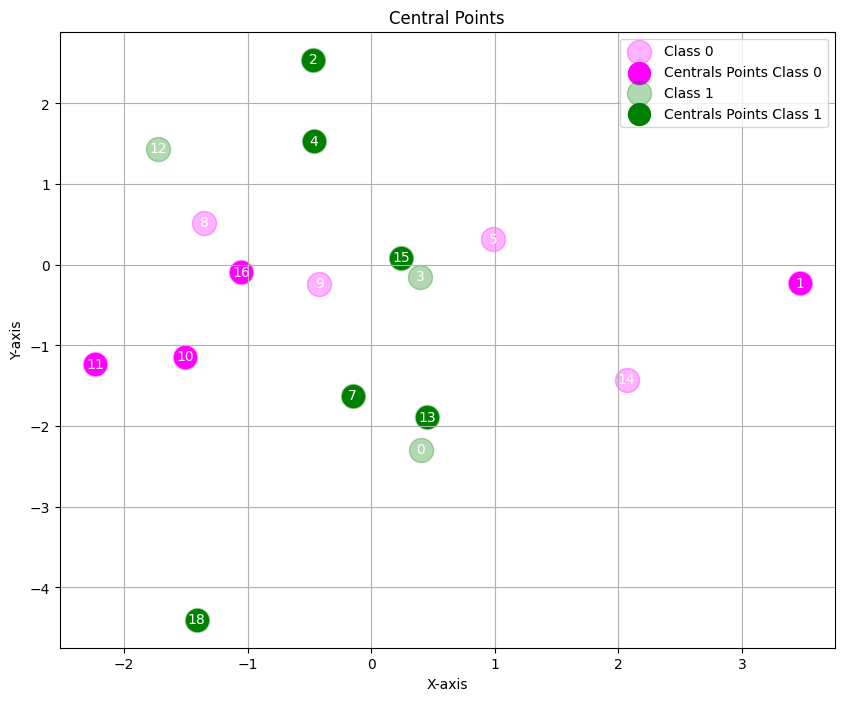

In [210]:
plot_central(X, y, kept_indices, central_indices)

#### 3. Inverse LS-clustering

10
[1, 2, 4, 7, 10, 11, 13, 15, 16, 18]
[[1], [2, 4, 15], [2, 4, 15], [7, 13], [10, 11, 16], [10, 11, 16], [7, 13, 15], [15], [10, 16], [7, 13, 18]]

10
[1, 15, 7, 16, 2, 4, 10, 11, 13, 18]
[[1], [15], [7, 13], [10, 16], [2, 4, 15], [2, 4, 15], [10, 11, 16], [10, 11, 16], [7, 13, 15], [7, 13, 18]]


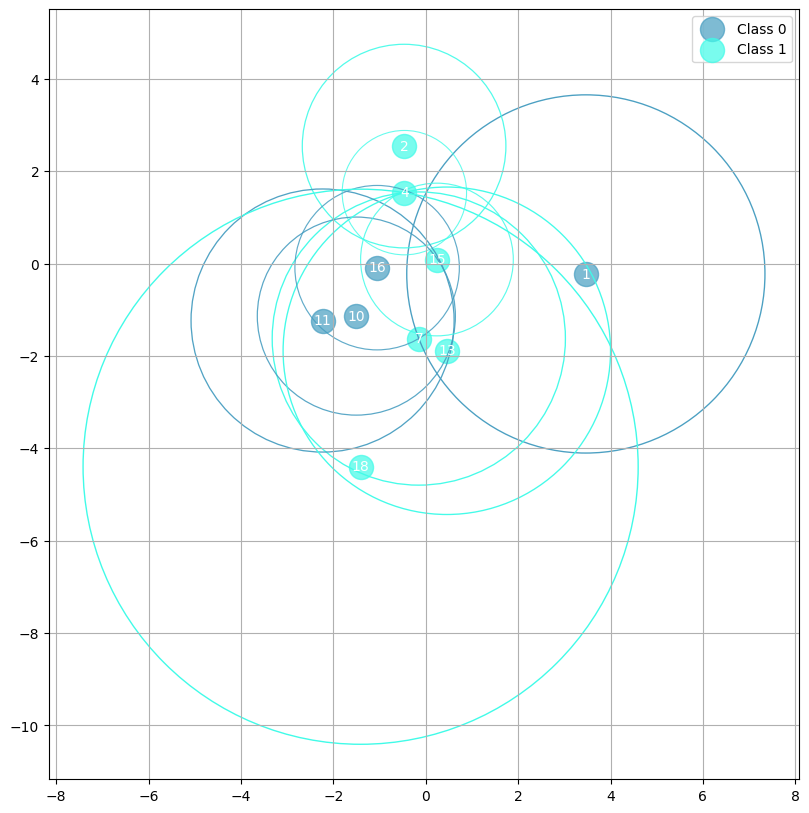

CPU times: total: 844 ms
Wall time: 859 ms


In [212]:
%%time

# Compute LS only of central indices
LSs, sorted_LSs_dict = compute_local_sets(X, y, central_indices) 

print(len(LSs))
print(list(LSs.keys())[0:10])
print(list(LSs.values())[0:10])
print()
print(len(sorted_LSs_dict))
print(list(sorted_LSs_dict.keys())[0:10])
print(list(sorted_LSs_dict.values())[0:10])

print_local_sets(X, y, central_indices)

In [216]:
%%time

from collections import defaultdict

def LS_based_clustering_INVERSE(sorted_LSs_dict, LSs): 
    '''
    Inverse Local Set Based Clustering: 
        Assigns each instance to the cluster of the medoid with the smallest local set cardinality that contains it 
        — i.e., inverse local set clustering.
    '''
    clusters = defaultdict(list)
    included_instances = set()

    # Process clusters from lowest to highest LSC
    for LS_key in sorted_LSs_dict.keys():
        if LS_key not in included_instances:
            cluster_instances = set(LSs[LS_key]) - included_instances
            included_instances.update(cluster_instances)
            clusters[LS_key] = list(cluster_instances)

    return clusters

clusters_inverse = LS_based_clustering_INVERSE(sorted_LSs_dict, LSs)
print(len(clusters_inverse))

7
CPU times: total: 0 ns
Wall time: 0 ns


In [217]:
print(clusters_inverse)
print(len(clusters_inverse))

defaultdict(<class 'list'>, {1: [1], 15: [15], 7: [13, 7], 16: [16, 10], 2: [2, 4], 11: [11], 18: [18]})
7


In [147]:
# NOT USED
%%time

def LS_based_clustering(sorted_LSC_indices, LSs): 
    '''
    Local Set Based Clustering: 
        Assigns each instance to the cluster of the medoid with the largest local set cardinality that contains it 
    '''
    clusters = defaultdict(list)
    included_instances = set()

    # Process clusters from highestto lowest LSC
    for LS_key in reversed(sorted_LSs_dict.keys()):
        if LS_key not in included_instances:
            cluster_instances = set(LSs[LS_key]) - included_instances
            included_instances.update(cluster_instances)
            clusters[LS_key] = list(cluster_instances)

    return clusters

LS_clusters= LS_based_clustering(sorted_LSs_dict, LSs)
print(len(LS_clusters))

3
CPU times: total: 0 ns
Wall time: 0 ns


In [218]:
import random as random 
import matplotlib.patches as mpatches

def plot_clusters(clusters, X, y):
    '''
    Plots a scatter plot with embeddings and their clusters.
    '''
    fig, ax = plt.subplots(figsize=(10, 10))
    legend_handles = []

    distances = euclidean_distances(X, X)
    NEs = ne_dist(y, distances)

    for key, values in clusters.items():
        for value in values:
            # Add index text inside the point
            plt.text(X[value][0], X[value][1], str(value), fontsize=10, ha='center', va='center', color='white',
                 bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.2'))
        
        radius = math.dist(X[key], X[NEs[key]])
        if y[key] == 0:
            circle = plt.Circle(X[key], radius, color='red', fill=False, linewidth=1)
            ax.add_patch(circle)
        else:
            circle = plt.Circle(X[key], radius, color='blue', fill=False, linewidth=1)
            ax.add_patch(circle)

        # Print points with a color that assignes them to clusters
    
        r = random.random() 
        b = random.random() 
        g = random.random() 
  
        color = (r, g, b)

        legend_handles.append(mpatches.Patch(color=color, label=f"cluster with medoid {key}"))
        
        for value in values:
            plt.scatter(X[value][0], X[value][1], color=color, s=300, alpha=0.7)

    plt.legend(handles=legend_handles)
    plt.grid(True)
     
    ax.set_aspect('equal')


    plt.show()

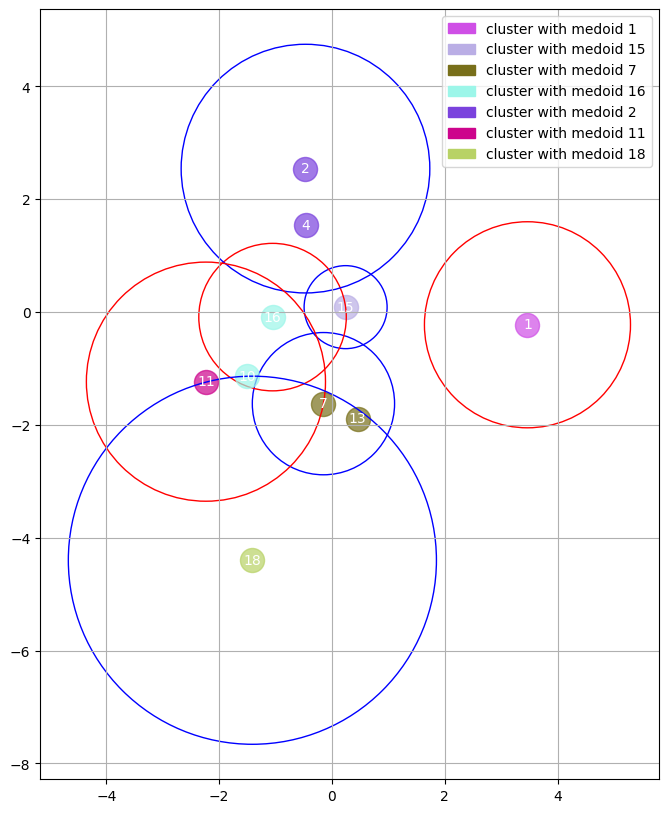

In [220]:
plot_clusters(clusters_inverse, X, y)

In [36]:
# OLD
# borders = clusters with cardinality = 1 (invasive points). All these points are selected
borders = list(k for k,v in clusters_inverse.items() if len(v) == 1)
print(borders[:10])
print(len(borders))

[9, 1, 12, 0, 15]
5


In [37]:
# OLD
# candidate clusters = clusters with cardinality > 1 (clusters containing instances that are candidates for selection). 
candidate_clusters = defaultdict(list, {k: v for k,v in clusters_inverse.items() if len(v) > 1})
print(list(candidate_clusters.items())[:10])
print(len(candidate_clusters))
print(list(candidate_clusters.items())[500:])

[(2, [2, 3]), (14, [6, 14]), (7, [8, 11, 7])]
3
[]


In [221]:
candidate_clusters = clusters_inverse
print(candidate_clusters)

defaultdict(<class 'list'>, {1: [1], 15: [15], 7: [13, 7], 16: [16, 10], 2: [2, 4], 11: [11], 18: [18]})


In [228]:
def compute_centroids(clusters, X):
    # clusters: defaultdict(int -> list of indices)
    # X: numpy array of shape (n_samples, n_features)
    centroids = {}
    for cluster_id, indices in clusters.items():
        if indices:  # avoid division by zero
            centroids[cluster_id] = np.mean(X[indices], axis=0)
        else:
            centroids[cluster_id] = np.zeros(X.shape[1])  # or handle empty case differently
    return centroids


In [229]:
centroids = compute_centroids(candidate_clusters, X)
print(list(centroids.items())[:10])

[(1, array([ 3.46564877, -0.2257763 ])), (15, array([0.24196227, 0.08671976])), (7, array([ 0.15231185, -1.7566897 ])), (16, array([-1.27832342, -0.61405343])), (2, array([-0.46644604,  2.03841515])), (11, array([-2.23415337, -1.23413696])), (18, array([-1.41077202, -4.39966159]))]


In [294]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from collections import defaultdict

def compute_centroid_border_distances(centroids, X, y, borders):
    distances = {}
    nearest_borders = {}

    # Group border indices by class
    class_to_borders = defaultdict(list)
    for idx in borders:
        class_to_borders[y[idx]].append(idx)

    for cluster_id, centroid in centroids.items():
        cluster_class = y[cluster_id]
        border_ids = class_to_borders.get(cluster_class, [])
        if not border_ids:
            distances[cluster_id] = np.inf
            nearest_borders[cluster_id] = None
            continue

        border_vectors = X[border_ids]
        dists = euclidean_distances(centroid.reshape(1, -1), border_vectors).flatten()
        min_idx = np.argmin(dists)
        distances[cluster_id] = dists[min_idx]
        nearest_borders[cluster_id] = border_ids[min_idx]

    return distances, nearest_borders



In [295]:
%%time
border_dists, nearest_borders = compute_centroid_border_distances(centroids, X, y, borders_lsbo)
for cluster_id, dist in border_dists.items():
    print(f"Cluster {cluster_id}: Nearest same-class border distance = {dist:.4f}")

print()
print(nearest_borders)

Cluster 1: Nearest same-class border distance = 1.8418
Cluster 15: Nearest same-class border distance = 0.2818
Cluster 7: Nearest same-class border distance = 0.5893
Cluster 16: Nearest same-class border distance = 0.9386
Cluster 2: Nearest same-class border distance = 1.3945
Cluster 11: Nearest same-class border distance = 1.9660
Cluster 18: Nearest same-class border distance = 2.7785

{1: 14, 15: 3, 7: 0, 16: 9, 2: 12, 11: 8, 18: 0}
CPU times: total: 0 ns
Wall time: 2.1 ms


In [296]:
import matplotlib.pyplot as plt
import numpy as np

def plot_centroids_and_borders(X, y, centroids, nearest_borders, colors=None):
    if colors is None:
        colors = ['blue', 'green', 'red', 'orange', 'magenta']

    plt.figure(figsize=(10, 8))

    # Plot all instances faded
    for i in range(2):  # Assuming 2 classes
        plt.scatter(X[y == i, 0], X[y == i, 1], alpha=0.3, s=300, color=colors[i], label=f'Class {i}')

    # Plot centroid-border connections
    for cluster_id, centroid in centroids.items():
        border_idx = nearest_borders[cluster_id]
        if border_idx is None:
            continue

        class_id = y[cluster_id]
        color = colors[class_id]

        # Draw line from centroid to border
        plt.plot([centroid[0], X[border_idx, 0]],
                 [centroid[1], X[border_idx, 1]],
                 linestyle='--', color=color, linewidth=2, alpha=0.7)

        # Mark centroid with diamond
        plt.scatter(centroid[0], centroid[1], marker='D', s=200, color='black', label='Centroid' if cluster_id == list(centroids.keys())[0] else "")

    # Annotate points
    for i, x in enumerate(X):
        plt.text(x[0], x[1], str(i), fontsize=10, ha='center', va='center', color='white',
                 bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.2'))

    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title("Centroid to Nearest Same-Class Border Connections")
    plt.legend()
    plt.grid(True)
    plt.show()


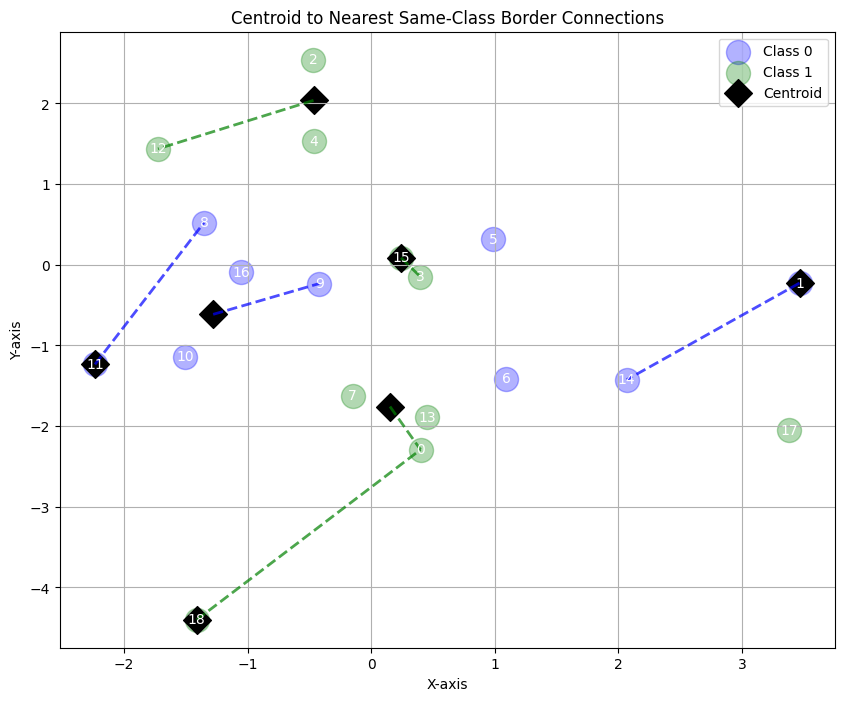

In [297]:
plot_centroids_and_borders(X, y, centroids, nearest_borders)

In [ ]:
#### 5. Preselecting clusters to fit in the number of decision variables

In [ ]:
num_decision_variables = 150
size = min(len(clusters_inverse_clean), num_decision_variables)
print(f'initial number of clusters: {len(clusters_inverse_clean)} \nnumber of decision variables:{num_decision_variables} \nfinal size: {size}')

#### 4. QUBO matrix definition

As we already did noise removal, here we are focused on removing redundancy (QUBO matrix that selects clusters likely near class boundaries)

Select a subset of clusters (or their representative instances) such that:

You minimize redundancy (e.g., overlapping information in the same class region).

You avoid selecting two clusters of the same class that are "not separated" by a border.

In [369]:
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def build_qubo_matrix(
    centroids,
    centroid_border_dists,
    y,
    clusters,
    alpha=1.0, # penalty scaling factor --> tune
    beta=1.0, # reward scaling factor --> tune
    T=0.0, # tolerance for inner distance (hard threshold) to decide how much separation is enough to avoid redundancy--> tune
    self_bias=-0.1, # -0.1 for enhancing sparse selection
    gamma=5.0  # class balance penalty strength
):
    cluster_ids = list(centroids.keys())
    n = len(cluster_ids)
    Q = np.zeros((n, n))

    class_vector = np.array([y[cid] for cid in cluster_ids])  # class of each cluster
    w = 1 - 2 * class_vector  # w[i] = +1 for class 0, -1 for class 1
    epsilon = 1e-6  # small constant to avoid division by zero
    
    # Main reward/penalty term
    for i in range(n):
        id_i = cluster_ids[i]
        class_i = y[id_i]
        c_i = centroids[id_i]
        d_i = centroid_border_dists[id_i]
        Q[i, i] = self_bias

        for j in range(i + 1, n):
            id_j = cluster_ids[j]
            class_j = y[id_j]

            c_j = centroids[id_j]
            d_j = centroid_border_dists[id_j]

            inter_dist = np.linalg.norm(c_i - c_j)
            delta = inter_dist - (d_i + d_j + T)
            
            if class_i != class_j:
                continue

            if delta < 0:
                # Same class clusters are on the same side of a margin: penalize
                # the smaller inner distance (more redundant), the worse the penalization
                penalization = 1 / (inter_dist + epsilon)
                Q[i, j] += alpha * penalization
                Q[j, i] += alpha * penalization
            else:
                # Same class clusters are on different sides of a margin: reward
                # the closer to the margin (i.e., smaller inner distance), the better the reward
                reward = 1 / (inter_dist + epsilon)
                Q[i, j] -= beta * reward
                Q[j, i] -= beta * reward

    # Add class balance constraint: (n_0 - n_1)^2
    Q += gamma * np.outer(w, w)

    return Q, cluster_ids


In [ ]:
# NOT USED
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def build_qubo_matrix(
    centroids,
    centroid_border_dists,
    y,
    clusters,
    alpha=1.0, # penalty scaling factor --> tune
    beta=1.0, # reward scaling factor --> tune
    T=0.0, # tolerance for inner distance (hard threshold) to decide how much separation is enough to avoid redundancy--> tune
    self_bias=-0.1, # -0.1 for enhancing sparse selection
    gamma=5.0  # class balance penalty strength
):
    cluster_ids = list(centroids.keys())
    n = len(cluster_ids)
    Q = np.zeros((n, n))

    class_vector = np.array([y[cid] for cid in cluster_ids])  # class of each cluster
    w = 1 - 2 * class_vector  # w[i] = +1 for class 0, -1 for class 1
    epsilon = 1e-6  # small constant to avoid division by zero
    
    # Main reward/penalty term
    for i in range(n):
        id_i = cluster_ids[i]
        class_i = y[id_i]
        c_i = centroids[id_i]
        d_i = centroid_border_dists[id_i]
        Q[i, i] = self_bias

        for j in range(i + 1, n):
            id_j = cluster_ids[j]
            class_j = y[id_j]

            c_j = centroids[id_j]
            d_j = centroid_border_dists[id_j]

            inter_dist = np.linalg.norm(c_i - c_j)
            delta = inter_dist - (d_i + d_j + T)
            
            if class_i != class_j:
                continue
            # Different class: reward if the inner distance is close to the distance to borders
                #  Proportional rewards/penalties based on how close or far clusters are compared to their border distances. (proportional to delta)
                #if delta < 0:
                    # Different class clusters are close: reward
                    # the closer to the margin (i.e., smaller inner distance), the better the reward
                    #Q[i, j] -= alpha * abs(delta)
                    #Q[j, i] -= alpha * abs(delta)
 
            #else:
            # Same class: reward if the inner distance is larger than the distance to borders.
                # The reward is proportional to the inner distance (if the margin condition is fulfilled, the the shorter the better, bc closer to margin)

            if delta < 0:
                # Same class clusters are on the same side of a margin: penalize
                # the smaller inner distance (more redundant), the worse the penalization
                penalization = 1 / (inter_dist + epsilon)
                Q[i, j] += alpha * penalization
                Q[j, i] += alpha * penalization
            else:
                # Same class clusters are on different sides of a margin: reward
                # the closer to the margin (i.e., smaller inner distance), the better the reward
                reward = 1 / (inter_dist + epsilon)
                Q[i, j] -= beta * reward
                Q[j, i] -= beta * reward

    # Add class balance constraint: (n_0 - n_1)^2
    Q += gamma * np.outer(w, w)

    return Q, cluster_ids

In [370]:
Q, cluster_ids = build_qubo_matrix(
    centroids,
    border_dists,
    y,
    candidate_clusters,
    alpha=1.3,  # penalty
    beta=1.1,   # reward
    T=0.2,      # high values make it more difficult for same class rewards
    self_bias=0.0
)


In [371]:
print(Q)
print(Q.shape[0])

[[ 5.         -5.         -5.          4.76889961 -5.          4.80996184
  -5.        ]
 [-5.          5.          4.40398436 -5.          4.47020773 -5.
   4.76992863]
 [-5.          4.40398436  5.         -5.          4.71393028 -5.
   5.42337107]
 [ 4.76889961 -5.         -5.          5.         -5.          6.14100218
  -5.        ]
 [-5.          4.47020773  4.71393028 -5.          5.         -5.
   4.83095038]
 [ 4.80996184 -5.         -5.          6.14100218 -5.          5.
  -5.        ]
 [-5.          4.76992863  5.42337107 -5.          4.83095038 -5.
   5.        ]]
7


In [372]:
import numpy as np
from itertools import product

def brute_force_qubo(Q):
    n = Q.shape[0]
    best_energy = float('inf')
    best_solution = None

    for x_tuple in product([0, 1], repeat=n):
        x = np.array(x_tuple)
        energy = x @ Q @ x  # Efficient way to compute xᵀQx

        if energy < best_energy:
            best_energy = energy
            best_solution = x.copy()

    return best_solution, best_energy


In [373]:
%%time

solution, energy = brute_force_qubo(Q)

print("Best solution (binary vector):", solution)
print("Minimum energy:", energy)

Best solution (binary vector): [1 1 1 1 0 0 0]
Minimum energy: -1.654232062241494
CPU times: total: 0 ns
Wall time: 1 ms


In [374]:
import numpy as np
import matplotlib.pyplot as plt

def plot_selected_instances(X, y, clusters, selected_cluster_ids, borders, noise=None):
    num_points = len(X)

    # Collect cluster-based selected points (excluding borders)
    selected_points = set()
    for cid in selected_cluster_ids:
        selected_points.update(clusters[cid])
    selected_points = selected_points - set(borders)  # exclude borders for separate plotting
    selected_points = np.array(sorted(selected_points))

    if noise is None:
        noise = []
    noise = np.array(noise)
    borders = np.array(borders)

    print(f"Selected cluster points (non-borders): {len(selected_points)}")
    print(f"Border points: {len(borders)}")
    print(f"Noise points: {len(noise)}")

    colors = ['blue', 'green', 'red', 'orange', 'magenta']

    plt.figure(figsize=(10, 8))

    for i in range(2):  # Assuming 2 classes
        # All points of class i (faded)
        plt.scatter(X[y == i, 0], X[y == i, 1], label=f'Class {i}', alpha=0.3, color=colors[i], s=300)

        # Selected non-border points with star
        selected_mask = (y == i) & (np.isin(np.arange(num_points), selected_points))
        plt.scatter(X[selected_mask, 0], X[selected_mask, 1],
                    alpha=1, color=colors[i], marker='*', s=300)

        # Border points with triangle
        border_mask = (y == i) & (np.isin(np.arange(num_points), borders))
        plt.scatter(X[border_mask, 0], X[border_mask, 1],
                    alpha=1, color=colors[i], marker='^', s=250, label=f'Borders Class {i}')

    # Noise points (cross)
    if len(noise) > 0:
        plt.scatter(X[noise, 0], X[noise, 1], color='black', marker='x', s=200, label='Noise')

    # Index labels
    for i, x in enumerate(X):
        plt.text(x[0], x[1], str(i), fontsize=10, ha='center', va='center', color='white',
                 bbox=dict(facecolor='none', edgecolor='none', boxstyle='round,pad=0.2'))

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Selected Points (Clusters, Borders as Triangles, Noise)')
    plt.legend()
    plt.grid(True)
    plt.show()




In [375]:
print(clusters_inverse)
print(borders_lsbo)

defaultdict(<class 'list'>, {1: [1], 15: [15], 7: [13, 7], 16: [16, 10], 2: [2, 4], 11: [11], 18: [18]})
[0, 3, 5, 8, 9, 12, 14]


In [376]:
selected_cluster_ids = []
for i, key in enumerate(candidate_clusters.keys()):
    if solution[i] == 1:
        selected_cluster_ids.append(key)
print(selected_cluster_ids)

[1, 15, 7, 16]


Selected cluster points (non-borders): 6
Border points: 7
Noise points: 2


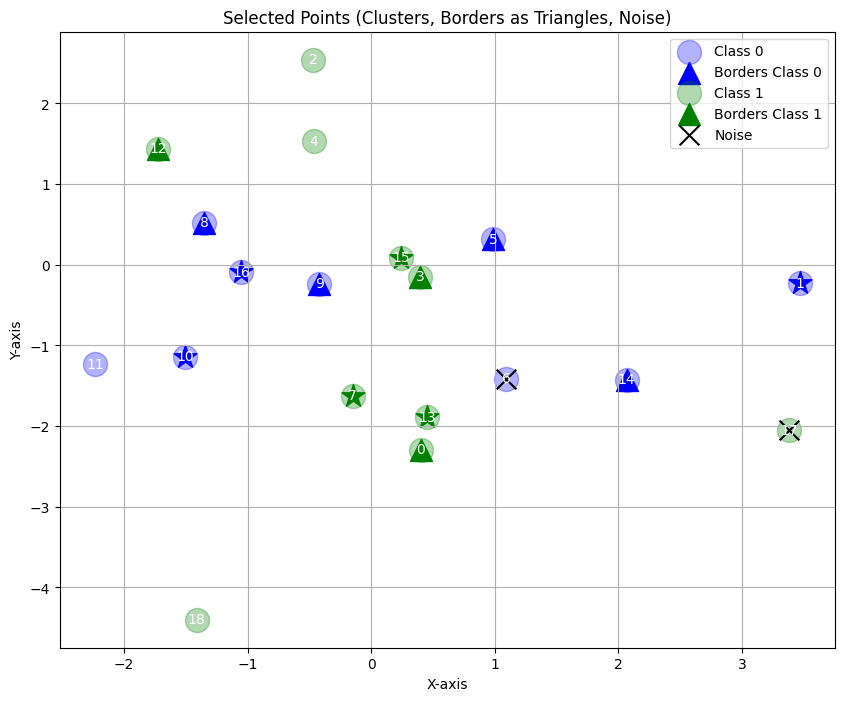

In [377]:
plot_selected_instances(X, y, clusters_inverse, selected_cluster_ids, borders_lsbo, noise_indices)